In [ ]:
#plt.ion()

# Sunpy Tutorial


Welcome to the Sunpy Tutorial. In this tutorial we will go over the basics to using Sunpy in your research. We will go over how to access data with FIDO, load and analyze images with Map, load and analyze time series data with TimeSeries, and cover some other general utilities to help your data exploration. 

Fundamentally Sunpy can be thought of as a broker between the python computing environment and solar physics data. Sunpy itself doesn't have much analysis software. It can't fit a curve or integrate intensity on its own. But Sunpy pulls the data produces by solar observatories into a format that other python packages can use and interact with. 

We will use some of these external packages to show how nicely Sunpy gets along with others. But first we need to get some data...

## Getting Some Data Using `Fido`

`Fido` is Sunpy's way to __FI__nd and __DO__wnload solar data. This tool looks for data irrespective of the underlying client or webservice through which the data is obtained, e.g. VSO, JSOC, etc. 

To get started, let's import `sunpy` and `Fido`. We are using the latest stable SunPy version, 0.9.3. 

In [1]:
import sunpy
sunpy.__version__

'0.9.3'

In [2]:
from sunpy.net import Fido

We also need some other libraries: attribuites in Sunpy and units from Astropy. 

In [3]:
from sunpy.net import attrs as a
import astropy.units as u

Now let's construct a simple search for AIA 171 images taken once every 10 minutes:

In [4]:
Fido.search(a.Time('2012/3/4 12:00:00', '2012/3/4 13:00:00'), a.Instrument('aia'), a.Wavelength(171*u.angstrom), a.vso.Sample(10*u.minute))


<sunpy.net.fido_factory.UnifiedResponse object at 0x11e52d780>
Results from 1 Provider:

7 Results from the VSOClient:
   Start Time [1]       End Time [1]    Source ...   Type   Wavelength [2]
                                               ...             Angstrom   
       str19               str19         str3  ...   str8      float64    
------------------- ------------------- ------ ... -------- --------------
2012-03-04 12:50:00 2012-03-04 12:50:01    SDO ... FULLDISK 171.0 .. 171.0
2012-03-04 12:30:00 2012-03-04 12:30:01    SDO ... FULLDISK 171.0 .. 171.0
2012-03-04 12:20:00 2012-03-04 12:20:01    SDO ... FULLDISK 171.0 .. 171.0
2012-03-04 12:00:00 2012-03-04 12:00:01    SDO ... FULLDISK 171.0 .. 171.0
2012-03-04 13:00:00 2012-03-04 13:00:01    SDO ... FULLDISK 171.0 .. 171.0
2012-03-04 12:10:00 2012-03-04 12:10:01    SDO ... FULLDISK 171.0 .. 171.0
2012-03-04 12:40:00 2012-03-04 12:40:01    SDO ... FULLDISK 171.0 .. 171.0

That search returned a table with 7 different results. But now lets assign this to a variable for easy access:

In [5]:
results = Fido.search(a.Time('2012/3/4 12:00:00', '2012/3/4 13:00:00'), a.Instrument('aia'), a.Wavelength(171*u.angstrom), a.vso.Sample(10*u.minute))


Get information about the results and select individual times by working with the results object: 

In [6]:
results.file_num

7

In [7]:
results[0,2:5]


<sunpy.net.fido_factory.UnifiedResponse object at 0x10384e588>
Results from 1 Provider:

3 Results from the VSOClient:
   Start Time [1]       End Time [1]    Source ...   Type   Wavelength [2]
                                               ...             Angstrom   
       str19               str19         str3  ...   str8      float64    
------------------- ------------------- ------ ... -------- --------------
2012-03-04 12:20:00 2012-03-04 12:20:01    SDO ... FULLDISK 171.0 .. 171.0
2012-03-04 12:00:00 2012-03-04 12:00:01    SDO ... FULLDISK 171.0 .. 171.0
2012-03-04 13:00:00 2012-03-04 13:00:01    SDO ... FULLDISK 171.0 .. 171.0

Downloading the files are easy using the Fido.fetch utility:

In [8]:
downloaded_files = Fido.fetch(results[0,5], path='/Users/mskirk/Desktop/{file}.fits')

[                                        ========================================


In [9]:
downloaded_files

['/Users/mskirk/Desktop/aia_lev1_171a_2012_03_04t12_10_00_34z_image_lev1.fits.fits']

In [10]:
type(downloaded_files)

list

In [11]:
len(downloaded_files)

1

## Image Analysis with `Map`

Now that we have an image downloaded, what can we do with it? The Sunpy module `Map` is designed to work with all types of solar imagry. 

In [12]:
from sunpy.map import Map

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [14]:
aia_map = Map(downloaded_files[0])

Getting a quick look at the AIA map is easy using `peek`:

<IPython.core.display.Javascript object>


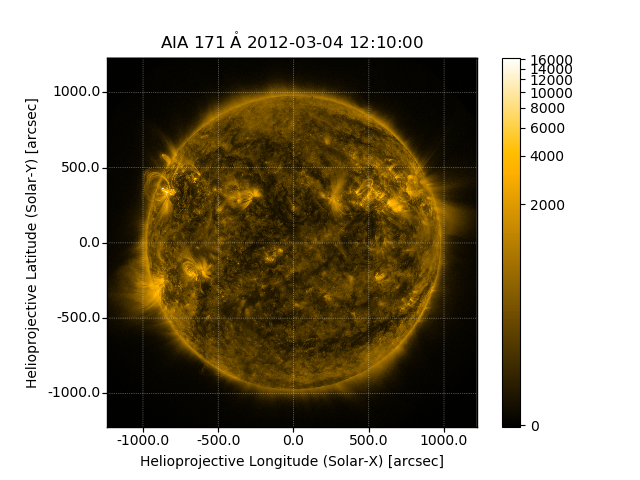

In [15]:
aia_map.peek()

Notice that the typical 'AIA Prep' routines have automatically been run as the .fits image was loaded into the map object. 

But looking at images is not good enough, how do we do some image manipulation? 

Rotating, cropping, and resampling images is easy using `Map`. But first we need some more libraries:

In [16]:
import astropy.units as u
from astropy.coordinates import SkyCoord

Using `SkyCoords`, we can select a submap region in helioprojective coordinates. Let's define our corner boundaries:

<IPython.core.display.Javascript object>


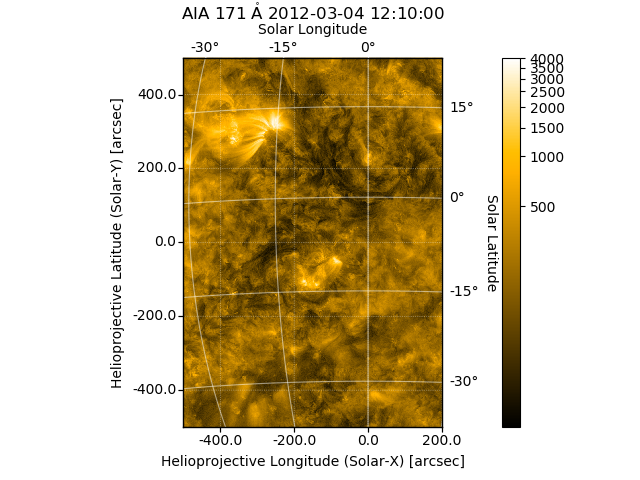

In [17]:
top_right = SkyCoord(200*u.arcsec, 500 * u.arcsec, frame=aia_map.coordinate_frame)
bottom_left = SkyCoord(-500 * u.arcsec, -500 * u.arcsec, frame=aia_map.coordinate_frame)
aia_submap = aia_map.submap(bottom_left, top_right)
aia_submap.peek(draw_limb=True, draw_grid=True)

And we can rotate our submap:

/Users/mskirk/anaconda3/lib/python3.6/site-packages/sunpy/image/transform.py:122: RuntimeWarning: Input data has been cast to float64
  warnings.warn("Input data has been cast to float64", RuntimeWarning)


<IPython.core.display.Javascript object>


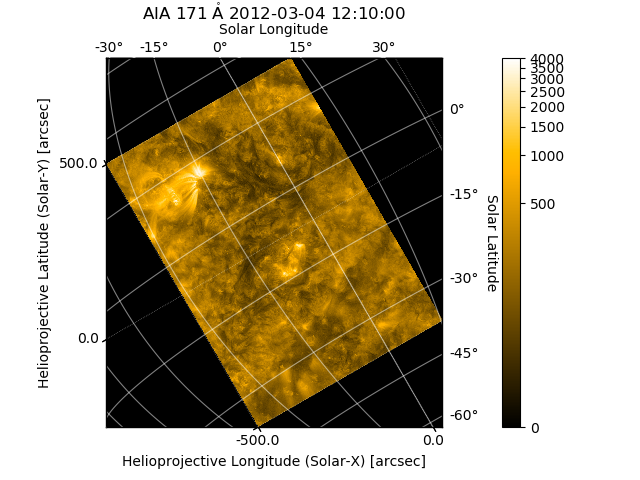

In [18]:
aia_rotated = aia_submap.rotate(angle = 30 * u.deg)
aia_rotated.peek(draw_limb=True, draw_grid=True)

And resample sample it:

<IPython.core.display.Javascript object>


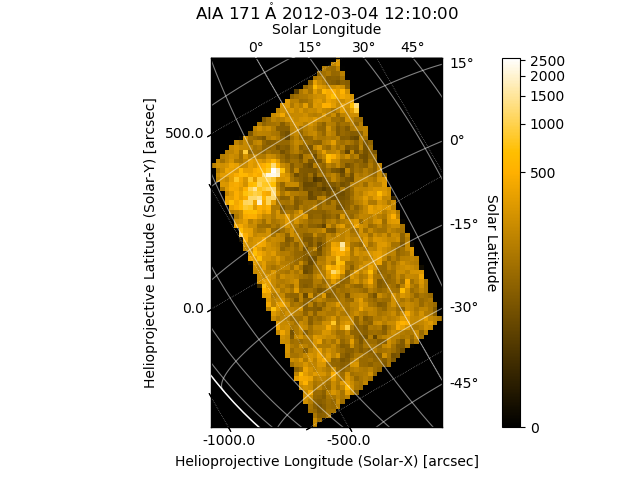

In [19]:
dimensions = u.Quantity([50, 80], u.pixel)
aia_resampled_map = aia_rotated.resample(dimensions)
aia_resampled_map.peek(draw_limb=True, draw_grid=True)

Lastly, lets isolate the top 5% of the bright regions in our original map: 

In [20]:
mask = aia_map.data < aia_map.max() * 0.05
mask.dtype

dtype('bool')

Mask is a boolean array. It can be used to modify the original map object without modifying the data. Once this mask attribute is set, we can plot the image again.

<IPython.core.display.Javascript object>


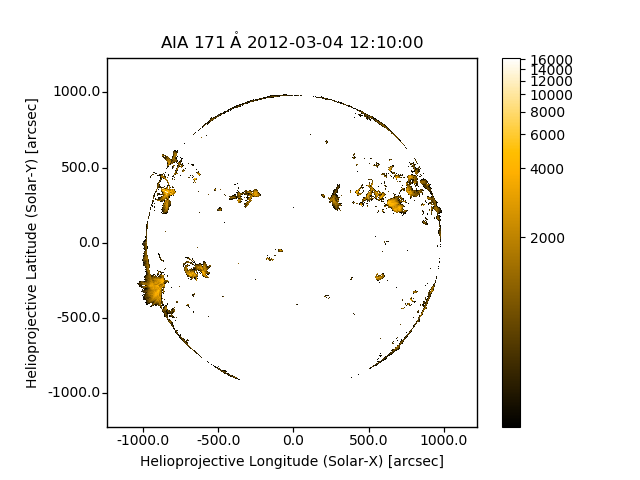

In [21]:
aia_map.mask = mask
aia_map.peek()

## Time Series Analysis With `TimeSeries`


To begin our work with time series, let's get some GOES XRS data using `Fido`:

In [22]:
results = Fido.search(a.Time('2012/3/4 12:00:00', '2012/3/4 13:00:00'), a.Instrument('GOES'))

In [23]:
results


<sunpy.net.fido_factory.UnifiedResponse object at 0x10fcc3518>
Results from 1 Provider:

1 Results from the XRSClient:
     Start Time           End Time      Source Instrument Wavelength
       str19               str19         str4     str4       str3   
------------------- ------------------- ------ ---------- ----------
2012-03-04 00:00:00 2012-03-04 23:59:59   nasa       goes        nan

In [24]:
downloaded_files = Fido.fetch(results[0], path='/Users/mskirk/Documents/Conferences/SDO 2018/')
downloaded_files

[                                        ========================================


['/Users/mskirk/Documents/Conferences/SDO 2018/go1520120304.fits']

Now let's import the `TimeSeries` module and load our data into it: 

In [25]:
import sunpy.timeseries as ts
import numpy as np

In [26]:
xrs_ts = ts.TimeSeries(downloaded_files, source='XRS')

We can look at the `TimeSeries` object using `peek` as well:

<IPython.core.display.Javascript object>


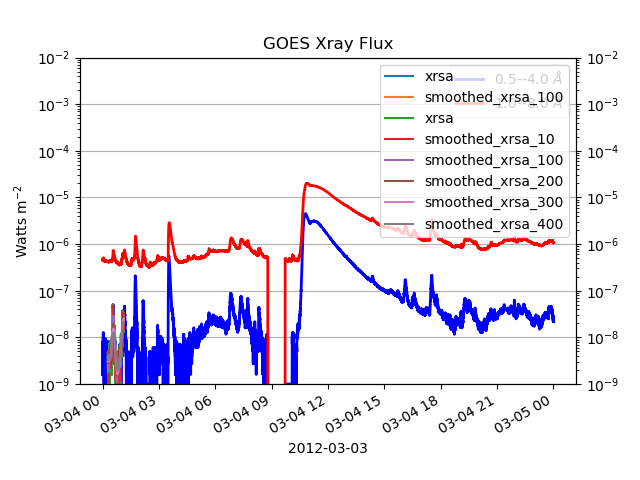

In [27]:
xrs_ts.peek()

We can look at the XRS dataframe directly:

In [28]:
xrs_ts.data

xrsa          xrsb
2012-03-03 23:59:58.438999  1.602000e-09  4.562800e-07
2012-03-04 00:00:00.488999  2.716500e-09  4.562800e-07
2012-03-04 00:00:02.534999  4.945400e-09  4.536600e-07
2012-03-04 00:00:04.581999  2.716500e-09  4.536600e-07
2012-03-04 00:00:06.631999  1.602000e-09  4.562800e-07
2012-03-04 00:00:08.678999  1.602000e-09  4.536600e-07
2012-03-04 00:00:10.728999  1.602000e-09  4.562800e-07
2012-03-04 00:00:12.774999  1.602000e-09  4.589000e-07
2012-03-04 00:00:14.821999  2.716500e-09  4.562800e-07
2012-03-04 00:00:16.871999  2.716500e-09  4.536600e-07
2012-03-04 00:00:18.918999  1.602000e-09  4.562800e-07
2012-03-04 00:00:20.968999  2.716500e-09  4.562800e-07
2012-03-04 00:00:23.014999  3.831000e-09  4.562800e-07
2012-03-04 00:00:25.061999  1.602000e-09  4.562800e-07
2012-03-04 00:00:27.111999  2.716500e-09  4.562800e-07
2012-03-04 00:00:29.158999  1.602000e-09  4.562800e-07
2012-03-04 00:00:31.208999  1.602000e-09  4.562800e-07
2012-03-04 00:00:33.254999  2.716500e-09  4.562800e-07
2012-03-04 00:00:35.301999  3.831000e-09  4.589000e-07
2012-03-04 00:00:37.351999  4.945400e-09  4.562800e-07
2012-03-04 00:00:39.398999  3.831000e-09  4.562800e-07
2012-03-04 00:00:41.448999  2.716500e-09  4.615300e-07
2012-03-04 00:00:43.494999  4.945400e-09  4.589000e-07
2012-03-04 00:00:45.541999  3.831000e-09  4.562800e-07
2012-03-04 00:00:47.591999  3.831000e-09  4.615300e-07
2012-03-04 00:00:49.638999  3.831000e-09  4.615300e-07
2012-03-04 00:00:51.688999  3.831000e-09  4.589000e-07
2012-03-04 00:00:53.734999  2.716500e-09  4.589000e-07
2012-03-04 00:00:55.781999  4.945400e-09  4.615300e-07
2012-03-04 00:00:57.831999  7.174300e-09  4.615300e-07
...                                  ...           ...
2012-03-04 23:58:56.908999  2.500600e-08  1.093700e-06
2012-03-04 23:58:58.958999  2.277700e-08  1.093700e-06
2012-03-04 23:59:01.004999  2.389100e-08  1.093700e-06
2012-03-04 23:59:03.054999  2.277700e-08  1.096400e-06
2012-03-04 23:59:05.101999  2.612000e-08  1.101600e-06
2012-03-04 23:59:07.148999  2.612000e-08  1.101600e-06
2012-03-04 23:59:09.198999  2.500600e-08  1.096400e-06
2012-03-04 23:59:11.244999  2.500600e-08  1.093700e-06
2012-03-04 23:59:13.294999  2.500600e-08  1.091100e-06
2012-03-04 23:59:15.341999  2.612000e-08  1.091100e-06
2012-03-04 23:59:17.388999  2.612000e-08  1.088500e-06
2012-03-04 23:59:19.438999  2.500600e-08  1.083200e-06
2012-03-04 23:59:21.484999  2.389100e-08  1.080600e-06
2012-03-04 23:59:23.534999  2.277700e-08  1.080600e-06
2012-03-04 23:59:25.581999  2.500600e-08  1.078000e-06
2012-03-04 23:59:27.628999  2.389100e-08  1.075400e-06
2012-03-04 23:59:29.678999  2.277700e-08  1.070100e-06
2012-03-04 23:59:31.724999  2.166200e-08  1.072700e-06
2012-03-04 23:59:33.774999  2.389100e-08  1.070100e-06
2012-03-04 23:59:35.821999  2.389100e-08  1.070100e-06
2012-03-04 23:59:37.868999  2.389100e-08  1.067500e-06
2012-03-04 23:59:39.918999  2.389100e-08  1.064900e-06
2012-03-04 23:59:41.964999  2.389100e-08  1.064900e-06
2012-03-04 23:59:44.011999  2.389100e-08  1.062200e-06
2012-03-04 23:59:46.061999  2.389100e-08  1.059600e-06
2012-03-04 23:59:48.108999  2.277700e-08  1.059600e-06
2012-03-04 23:59:50.158999  2.166200e-08  1.059600e-06
2012-03-04 23:59:52.204999  2.277700e-08  1.057000e-06
2012-03-04 23:59:54.251999  2.277700e-08  1.057000e-06
2012-03-04 23:59:56.301999  2.166200e-08  1.057000e-06

[41876 rows x 2 columns]

Now let's smooth our time series using a convolutional filter.

In [29]:
from astropy.convolution import convolve, Box1DKernel
import matplotlib.pyplot as plt

Now we will extract data values from the `TimeSeries` and apply a `BoxCar` filter to get smooth data. Boxcar smoothing is equivalent to taking our signal and using it to make a new signal where each element is the average of w adjacent elements. Here we will use AstroPy’s `convolve` function with a “boxcar” kernel of width w = 100.

In [30]:
xrs_ts.data['smoothed_xrsa_100'] =  convolve(xrs_ts.data['xrsa'].values, kernel=Box1DKernel(100))

/Users/mskirk/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/mskirk/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/mskirk/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/mskirk/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/mskirk/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [31]:
plt.plot(xrs_ts.data['xrsa'][500:2000])
plt.plot(xrs_ts.data['smoothed_xrsa_100'][500:2000])
plt.legend()
plt.xlabel('Date')
plt.yscale('log')

Now let's do the same with a few different kernels and overplot the results.

In [32]:
xrs_ts.data['smoothed_xrsa_10'] =  convolve(xrs_ts.data['xrsa'].values, kernel=Box1DKernel(10))
xrs_ts.data['smoothed_xrsa_200'] =  convolve(xrs_ts.data['xrsa'].values, kernel=Box1DKernel(200))
xrs_ts.data['smoothed_xrsa_300'] =  convolve(xrs_ts.data['xrsa'].values, kernel=Box1DKernel(300))
xrs_ts.data['smoothed_xrsa_400'] =  convolve(xrs_ts.data['xrsa'].values, kernel=Box1DKernel(400))

In [33]:
plt.plot(xrs_ts.data['xrsa'][500:2000])
plt.plot(xrs_ts.data['smoothed_xrsa_10'][500:2000])
plt.plot(xrs_ts.data['smoothed_xrsa_100'][500:2000])
plt.plot(xrs_ts.data['smoothed_xrsa_200'][500:2000])
plt.plot(xrs_ts.data['smoothed_xrsa_300'][500:2000])
plt.plot(xrs_ts.data['smoothed_xrsa_400'][500:2000])
plt.legend()
plt.xlabel('Date')
plt.yscale('log')

There are a lot more tools to help you visualize your data. Let's play around with one called `LineAnimator`, but first we must get the data into a specific array shape:

In [34]:
from sunpy.visualization.imageanimator import LineAnimator

#In the future release of SunPy, Line Animator is moving:
#from sunpy.visualization.animator.line import LineAnimator

In [35]:
data0 = np.transpose(xrs_ts.data[['xrsa','smoothed_xrsa_10','smoothed_xrsa_100','smoothed_xrsa_200','smoothed_xrsa_300','smoothed_xrsa_400']].values)
data0.shape

(6, 41876)

And create an array of times that correspond to this array:


In [36]:
xdata = xrs_ts.index.hour.values
xdata = np.tile(xrs_ts.index, (6, 1))

In [37]:
xdata.shape == data0.shape

True

In [38]:
xdata


array([['2012-03-03T23:59:58.438999000', '2012-03-04T00:00:00.488999000',
        '2012-03-04T00:00:02.534999000', ...,
        '2012-03-04T23:59:52.204999000', '2012-03-04T23:59:54.251999000',
        '2012-03-04T23:59:56.301999000'],
       ['2012-03-03T23:59:58.438999000', '2012-03-04T00:00:00.488999000',
        '2012-03-04T00:00:02.534999000', ...,
        '2012-03-04T23:59:52.204999000', '2012-03-04T23:59:54.251999000',
        '2012-03-04T23:59:56.301999000'],
       ['2012-03-03T23:59:58.438999000', '2012-03-04T00:00:00.488999000',
        '2012-03-04T00:00:02.534999000', ...,
        '2012-03-04T23:59:52.204999000', '2012-03-04T23:59:54.251999000',
        '2012-03-04T23:59:56.301999000'],
       ['2012-03-03T23:59:58.438999000', '2012-03-04T00:00:00.488999000',
        '2012-03-04T00:00:02.534999000', ...,
        '2012-03-04T23:59:52.204999000', '2012-03-04T23:59:54.251999000',
        '2012-03-04T23:59:56.301999000'],
       ['2012-03-03T23:59:58.438999000', '2012-03-04T00:

Using `LineAnimator` we can see how a smoothing funciton changes our line profile:

<IPython.core.display.Javascript object>


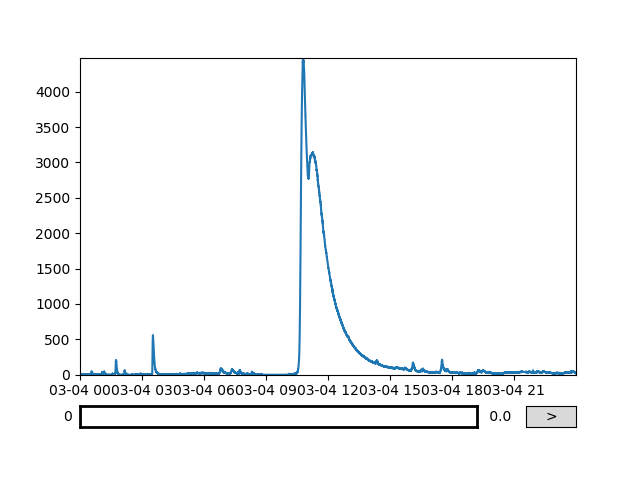

In [39]:
ani = LineAnimator((data0*1e9), plot_axis_index=1, axis_ranges=[None, xdata])

## General Utilities (that will aid your data exploration)
SunPy's great strenght is helping you get your data to "play well" with other software suites. One of the great packages that help you do this is `coordinates`.

With `coordinates` you can define your coordinate system and then transform them into complimentary systems. 

In [40]:
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames

Defining a coordinate frame is easy in sunpy. For example, let's define a point in helio-projective coordinate space (i.e. a solar image):

In [41]:
c = SkyCoord(100*u.arcsec, 100*u.arcsec, frame=frames.Helioprojective, obstime="2018-11-01")
c

<SkyCoord (Helioprojective: obstime=2018-11-01 00:00:00, rsun=695508.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2018-11-01 00:00:00): (lon, lat, radius) in (deg, deg, AU)
    (0., 4.40663314, 0.99263959)>): (Tx, Ty) in arcsec
    (100., 100.)>

Transformations are easy:

In [42]:
c.transform_to(frames.HeliographicCarrington)

<SkyCoord (HeliographicCarrington: obstime=2018-11-01 00:00:00): (lon, lat, radius) in (deg, deg, km)
    (298.35559058, 10.29649402, 695508.00000086)>

You can also easily change the observer location for different locations anywhere in the solar system. This system also maps the WCS coordinate convetion into more user friendly formats. 

Solar data is associated with a number of different time formats. SunPy provides a simple parsing function which can deal with most every format that a user may encounter. Called `sunpy.time.parse_time`, this function takes a string as input and returns a datetime object. 

Working with spectral data in SunPy is possible, but is underdeveloped. Specific packages are currently being designed to work with specific spectrograms on a case by case basis.

### A look forward to in SunPy version 1.0

SunPy is currently expanding. Affiliated packages include IRISpy (for IRIS analysis, https://github.com/sunpy/irispy) and NDCube (for hyper dimensional data analysis, https://github.com/sunpy/ndcube). Many more affilated packages are in development: Sunkit-Image (solar image processing, https://github.com/sunpy/sunkit-image) Fiasco (Python interface to the CHIANTI atomic database http://fiasco.readthedocs.io/), HelioPy (in situ heliosphereic data analysis http://docs.heliopy.org/en/stable/), and many more...